In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


In [2]:
import numpy as np
import pandas as pd

train = False

Find lead mutations among the successful mutants
- Highly occurrent mutation combinates among top activity variants (mutation combinations, mc)
- Rank by multiple metrics: mc activity, mean activity of mc covered variants, max activity of mc covered variants

## Obtain mutation combinations
- concur in at least 100 variants
- for variants fulfill the above requirement, the maximum number of mutations is found to be 7

In [3]:
def get_mutation_combs(unique_muts, sample2muts, n_muts=10, occur_threshold=100):
    if n_muts == 1:
        mutation_combs = {1:{}}
        for mut in unique_muts:
            mut_samples = [s_idx for s_idx in range(len(sample2muts)) if mut in sample2muts[s_idx]]
            if len(mut_samples) >= occur_threshold:
                mutation_combs[1][mut] = set(mut_samples)
        return mutation_combs
    
    mutation_combs = get_mutation_combs(unique_muts, sample2muts, n_muts=n_muts-1, occur_threshold=occur_threshold)
    
    mutation_combs[n_muts] = {}
    for mut_comb in mutation_combs[n_muts-1].keys():
        last_mut = mut_comb.split('/')[-1]
        last_mut_idx = unique_muts.index(last_mut)
        for new_mut_idx in range(last_mut_idx+1, len(unique_muts)):
            new_mut = unique_muts[new_mut_idx]
            if new_mut not in mutation_combs[1]:
                continue

            mut_samples = set(mutation_combs[n_muts-1][mut_comb]).intersection(mutation_combs[1][new_mut])
            if len(mut_samples) >= occur_threshold:
                mutation_combs[n_muts][f"{mut_comb}/{new_mut}"] = mut_samples
    return mutation_combs


def get_mutcomb_df(df_succ, occur_threshold=100):
    sample2muts = [muts.split('/') if '/' in muts else [muts] for muts in df_succ.mutations]
    unique_muts = list(set([mut for muts in sample2muts for mut in muts]))
    if '' in unique_muts:
        unique_muts.remove('')

    mutation_combs = get_mutation_combs(unique_muts, sample2muts, n_muts=8, occur_threshold=occur_threshold)

    df_mutation_combs = pd.DataFrame([(n_muts, mut_comb, 
                                       len(mutation_combs[n_muts][mut_comb]), 
                                       mutation_combs[n_muts][mut_comb])
                                       for n_muts in mutation_combs.keys() 
                                       for mut_comb in mutation_combs[n_muts].keys()],
                                    columns =['N_muts', 'Mut_comb', 'N_mutants', 'Mutant_index'])
    
    df_mutation_combs.sort_values(by=['N_mutants'], ascending=False, inplace=True)
    display(df_mutation_combs.sample(5))
    return df_mutation_combs

In [4]:
# train = True 

success_save_path = 'data/round1/dry-lab/results/all_step_aa_seqs.csv_success.csv_uniq.csv'

if train:
    df_succ_data = pd.read_csv(success_save_path+'_pred.csv')
    print(list(df_succ_data.columns))
    print(len(df_succ_data), df_succ_data.n_muts.min(), df_succ_data.n_muts.max(), df_succ_data.step.max())

    df_mutation_combs = get_mutcomb_df(df_succ_data, occur_threshold=10)
    df_mutation_combs.to_csv(success_save_path+'_mut_combs.csv', index=False)
else:
    df_mutation_combs = pd.read_csv(success_save_path+'_mut_combs.csv')
    df_mutation_combs['Mutant_index'] = [[int(idx) for idx in idx_str[1:-1].split(', ')] for idx_str in df_mutation_combs.Mutant_index]

print(list(df_mutation_combs.columns))
len(df_mutation_combs)

['N_muts', 'Mut_comb', 'N_mutants', 'Mutant_index', 'seq', 'mean_mc_mutant_act', 'max_mc_mutant_act', 'activity']


36406

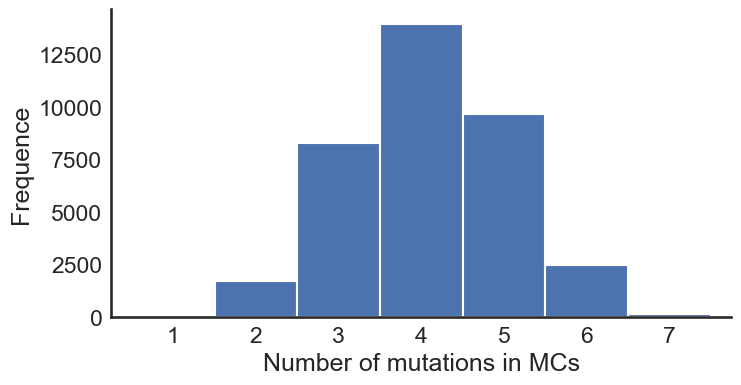

In [5]:
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")

fig, ax = plot_style_utils.simple_ax(figsize=(8, 4))
plot_style_utils.prettify_ax(ax)

df_mutation_combs['N_muts'].groupby(df_mutation_combs['N_muts']).count().plot.bar(ax=ax, width=1.0)
ax.set_xlabel('Number of mutations in MCs')
ax.set_ylabel('Frequence')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plot_style_utils.save_for_pub(fig, path='figures/mc_n_mutations', dpi=300)

## Rank by weighted activity

In [6]:
subtilisin_BPN = 'AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGGASMVPSETNPFQDNNSHGTHVAGTVAALNNSIGVLGVAPSASLYAVKVLGADGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAAL' \
    'KAAVDKAVASGVVVVAAAGNEGTSGSSSTVGYPGKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSIQSTLPGNKYGAYNGTSMASPHVAGAAALILSKHPNWTNTQVRSSLENTTTKLGDSFYYGKGLINVQAAAQ'

def get_seqs_for_mutants(mutant_mutations):
    mutant_seqs = [subtilisin_BPN] * len(mutant_mutations)
    for i in range(len(mutant_mutations)):
        for mut in mutant_mutations[i].split('/'):
            aa_ref, aa_mut = mut[0], mut[-1]
            pos = int(mut[1:-1])
            if aa_ref == mutant_seqs[i][pos-1]:
                mutant_seqs[i] = mutant_seqs[i][:pos-1] + aa_mut + mutant_seqs[i][pos:]
            else:
                raise Exception(f'Mutation {mut} not match reference, Variant {mutant_mutations[i]}')
    return mutant_seqs

In [21]:
from popscorer.fitness.ev_onehot import EVOnehotFitness
from easydict import EasyDict as edict
config = {
    'seq_len': 275,
    'predictor': {'data_path': 'data/round1/dry-lab/activity/',},
    'transform': {'trans_type': 'sigmoid', 'low': 1.0, 'high': 10.0},
    'min_val': 64,
}
config = edict(config)

def get_raw_activity_score(aa_seqs):
    score, raw_score = EVOnehotFitness(config)(aa_seqs)
    return raw_score

def get_mean_max_mutant_activities_of_MC(mutant_index):
    s_activies = [df_succ_data.iloc[idx].raw_Activity for idx in mutant_index]
    return np.mean(s_activies), np.max(s_activies)

In [22]:
from statsmodels.distributions.empirical_distribution import ECDF

def get_emperical_probability(samples):
    """Estimate emperical probability based on following equation:
        F(t) = (Number of samples <= t )/ Total number of samples
    """
    ecdf = ECDF(samples)
    return [ecdf(sample) for sample in samples]    

In [23]:
# train = True
train = False

if train:
    # mc activity
    df_mutation_combs['seq'] = get_seqs_for_mutants(df_mutation_combs.Mut_comb)
    df_mutation_combs['activity'] = get_raw_activity_score(df_mutation_combs.seq)
    print(len(df_mutation_combs), sum(df_mutation_combs.activity >= 0))

    # Get mean/max mutant activity of MC covered mutants
    df_mutation_combs[['mean_mc_mutant_act', 'max_mc_mutant_act']] = df_mutation_combs[['Mutant_index']]\
    .apply(lambda x: get_mean_max_mutant_activities_of_MC(x.Mutant_index), axis=1, result_type='expand')

    df_mutation_combs['normed_activity'] = get_emperical_probability(df_mutation_combs.activity)
    df_mutation_combs['normed_N_mutants'] = get_emperical_probability(df_mutation_combs.N_mutants)
    df_mutation_combs['normed_mean_mc_mutant_act'] = get_emperical_probability(df_mutation_combs.mean_mc_mutant_act)
    df_mutation_combs['normed_max_mc_mutant_act'] = get_emperical_probability(df_mutation_combs.max_mc_mutant_act)

    # The average of MC activities, number of variants, and mean & max of variant activities
    df_mutation_combs['score'] = df_mutation_combs[['normed_activity', 'normed_mean_mc_mutant_act', 'normed_max_mc_mutant_act']].mean(axis=1)

    df_mc_scored = df_mutation_combs[['N_muts', 'Mut_comb', 'N_mutants', 'activity', 'mean_mc_mutant_act', 'max_mc_mutant_act', 'score']].copy()

    df_mc_scored = df_mc_scored.sort_values(by=['score'], ascending=False)
    df_mc_scored.to_csv(success_save_path+'_mut_combs_scored.csv', index=False)
else:
    df_mc_scored = pd.read_csv(success_save_path+'_mut_combs_scored.csv')

print(len(df_mc_scored))
df_mc_scored.head(10)

36406


,N_muts,Mut_comb,N_mutants,activity,mean_mc_mutant_act,max_mc_mutant_act,score
0,6,N218S/M50F/K213R/G169A/Y217L/S224A,27,3.011677,3.500859,4.328210,0.996933
1,5,N218S/M50F/G169A/S224A/K43N,12,2.647283,3.780365,4.328210,0.991439
2,4,M50F/K213R/S224A/K43N,10,3.749422,2.943847,4.328210,0.989983
3,5,M50F/K213R/S224A/M124L/K43N,10,3.517116,2.943847,4.328210,0.989745
4,7,N218S/K256Y/G169A/Y217L/S224A/S3T/M124L,13,2.636528,3.325644,4.285493,0.987539
5,7,N218S/K213R/G169A/Y217L/S224A/M124L/K43N,10,2.473466,3.350536,4.328210,0.985607
6,4,M50F/K256Y/S224A/S3T,15,2.695726,3.020215,4.285493,0.983721
7,6,N218S/K256Y/G169A/Y217L/S224A/S3T,13,2.469083,3.325644,4.285493,0.983071
8,7,N218S/G169A/Y217L/S224A/M124L/K43N/K213E,12,2.621865,3.099961,4.218337,0.979692
9,4,N218S/K256Y/S224A/K43N,14,2.898194,3.028541,4.172987,0.979665


### Show top MCs

In [11]:
def sort_mutation_in_mc(mut_comb):
    mutations = mut_comb.split('/')
    mut_pos = [int(mut[1:-1]) for mut in mutations]
    mut_pos_idx = np.argsort(mut_pos)
    mutations_sorted = [mutations[idx] for idx in mut_pos_idx]
    return '/'.join(mutations_sorted)

# sort_mutation_in_mc('G169A/K213Y/N218S/K256N/Y217L/M50F')

,N_muts,Mut_comb,N_mutants,activity,mean_mc_mutant_act,max_mc_mutant_act,score
9,4,N218S/K256Y/S224A/K43N,14,2.898194,3.028541,4.172987,0.979665
8,7,N218S/G169A/Y217L/S224A/M124L/K43N/K213E,12,2.621865,3.099961,4.218337,0.979692
7,6,N218S/K256Y/G169A/Y217L/S224A/S3T,13,2.469083,3.325644,4.285493,0.983071
6,4,M50F/K256Y/S224A/S3T,15,2.695726,3.020215,4.285493,0.983721
5,7,N218S/K213R/G169A/Y217L/S224A/M124L/K43N,10,2.473466,3.350536,4.328210,0.985607
4,7,N218S/K256Y/G169A/Y217L/S224A/S3T/M124L,13,2.636528,3.325644,4.285493,0.987539
3,5,M50F/K213R/S224A/M124L/K43N,10,3.517116,2.943847,4.328210,0.989745
2,4,M50F/K213R/S224A/K43N,10,3.749422,2.943847,4.328210,0.989983
1,5,N218S/M50F/G169A/S224A/K43N,12,2.647283,3.780365,4.328210,0.991439
0,6,N218S/M50F/K213R/G169A/Y217L/S224A,27,3.011677,3.500859,4.328210,0.996933


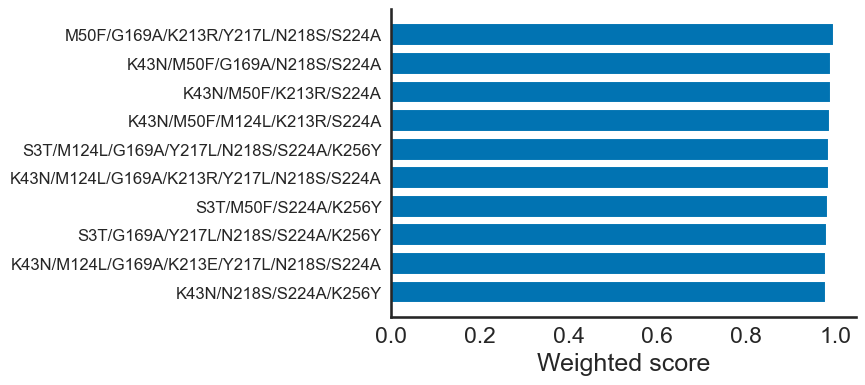

In [13]:
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

topn=10
df_topn_mc = df_mc_scored.nlargest(topn, 'score').sort_values(by='score', ascending=True)#.reset_index()# .mutation
display(df_topn_mc)
df_topn_mc['Mut_comb'] = [sort_mutation_in_mc(mut_comb) for mut_comb in df_topn_mc.Mut_comb]

ax.barh(df_topn_mc.Mut_comb, df_topn_mc.score, color=plot_style_utils.CAT_PALETTE[0])
ax.set_xlabel('Weighted score')
ax.yaxis.set_ticks(np.arange(len(df_topn_mc)))
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plot_style_utils.save_for_pub(fig, path='figures/round1/mc_top10_ranking')